In [6]:
from module import td3

import numpy as np
import gym
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Bipedal walker:  https://www.gymlibrary.dev/environments/box2d/bipedal_walker/


In [2]:
env = gym.make('BipedalWalker-v3', hardcore=False, render_mode='human')

# Get the state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print(state_size, action_size)

24 4


In [3]:
def normalize(state) -> np.array:
    """
    Normalize the state -> in range [-1, 1]
    """
    return state / env.observation_space.high

In [13]:
# training
env = gym.make('BipedalWalker-v3', hardcore=False, render_mode='human')
agent = td3.TD3Agent(state_size, action_size,
                        training_start=1000, update_period=10,
                        lr_actor=10**-4, lr_critic=10**-4,
                        noise_std=1.0, noise_decay=0.995,
                        min_noise_std=0.05, noise_boundary=0.9,
                        exploration_prob=1.0, exploration_prob_decay=0.9995,
                        min_exploration_prob=0.1)
score_history = []
avg_score_history = []

n_episodes = 10000

In [14]:
# loading the model if needed, comment these if training from scratch
agent.actor_eval = load_model('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/actor_eval.keras')
agent.actor_target = load_model('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/actor_target.keras')
agent.critic_eval_1 = load_model('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_eval_1.keras')
agent.critic_eval_2 = load_model('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_eval_2.keras')
agent.critic_target_1 = load_model('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_target_1.keras')
agent.critic_target_2 = load_model('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_target_2.keras')

In [4]:
for i in range(n_episodes):
    # decay the exploration probability
    agent.exploration_prob = max(agent.exploration_prob * agent.exploration_prob_decay, agent.min_exploration_prob)
    done = False
    score = 0
    state = env.reset()
    state = state[0].reshape([1, state_size])
    # normalize
    state = normalize(state)
    time_step = 0  # to count number of steps in an episode
    rewards = []
    while not done:
        time_step += 1
        action = agent.act(state, use_noise=True, noise_label='Gaussian')
        next_state, reward, done, _, _ = env.step(action)
        next_state = next_state.reshape([1, state_size])
        # normalize
        next_state = normalize(next_state)
        # we shape the reward: added with the horizontal velocity x 10
        # to make sure the walker moves forward
        shaped_reward = reward + state[0][2] * 10
        agent.store_data(state, action, shaped_reward, next_state, done)
        agent.learn()
        state = next_state
        score += reward
        # we early break for the first 1200 episodes since the walker might get stuck.
        # After this point, the walker slightly know how to walk, so let him explore
        # the entire route freely.
        if i < 1200 and time_step > 1000:
            print('break the episode')
            break
        
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    avg_score_history.append(avg_score)
    print('Episode: ', i, '- Score: ', round(score, 3), '- Avg score: ', round(avg_score, 3), '- Explore prob ', round(agent.exploration_prob, 3), '- End after: ', time_step )
    
    if avg_score > 300:
        print('Training done')
        break

/Users/sondinhvan/miniconda3/envs/rl_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Collect enough samples, training starting
break the episode
Episode:  0 - Score:  -57.017 - Avg score:  -57.017 - Explore prob  1.0 - End after:  1001
Episode:  1 - Score:  -118.767 - Avg score:  -87.892 - Explore prob  0.999 - End after:  74
break the episode
Episode:  2 - Score:  -62.537 - Avg score:  -79.44 - Explore prob  0.999 - End after:  1001
Episode:  3 - Score:  -107.333 - Avg score:  -86.413 - Explore prob  0.998 - End after:  68
Episode:  4 - Score:  -107.431 - Avg score:  -90.617 - Explore prob  0.998 - End after:  68
Episode:  5 - Score:  -117.137 - Avg score:  -95.037 - Explore prob  0.997 - End after:  143
Episode:  6 - Score:  -111.956 - Avg score:  -97.454 - Explore prob  0.997 - End after:  64
Episode:  7 - Score:  -119.999 - Avg score:  -100.272 - Explore prob  0.996 - End after:  156
Episode:  8 - Score:  -111.457 - Avg score:  -101.515 - Explore prob  0.996 - End after:  61
break the episode
Episode:  9 - Score:  -62.285 - Avg score:  -97.592 - Explore prob  0.995

KeyboardInterrupt: 

In [21]:
env = gym.make('BipedalWalker-v3', hardcore=False, render_mode='human')
state = env.reset()
state = np.reshape(state[0], [1, state_size])
done = False
score = 0
while not done:
    # normalize the state before feeding to the model
    state = normalize(state)
    action = agent.act(state, use_noise=False)
    next_state, reward, done, _, _ = env.step(action)
    next_state = next_state.reshape(1, state_size)
    
    state = next_state
    score += reward

print(score)

/Users/sondinhvan/miniconda3/envs/rl_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


319.6322086202154


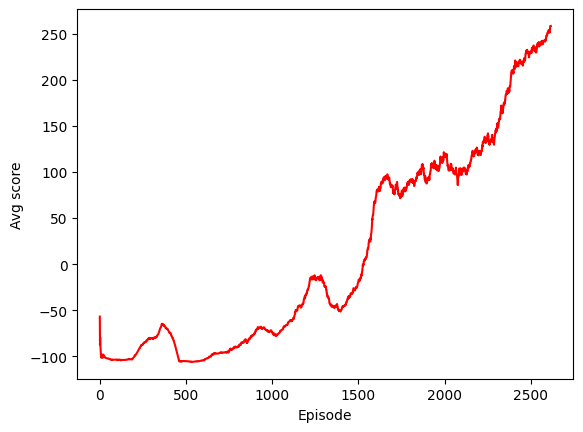

In [14]:
plt.plot(avg_score_history, color = 'red')
plt.xlabel('Episode')
plt.ylabel('Avg score')
plt.savefig('td3_bipedal_walker_easy.png')

In [16]:
agent.critic_eval_1.save('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_eval_1.keras')
agent.critic_eval_2.save('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_eval_2.keras')
agent.critic_target_1.save('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_target_1.keras')
agent.critic_target_2.save('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/critic_target_2.keras')
agent.actor_eval.save('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/actor_eval.keras')
agent.actor_target.save('../../docs/td3_bipedal_walker/td3_bipedal_walker_easy_model/actor_target.keras')